In [1]:
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim
from sklearn.metrics import confusion_matrix
from elpv_reader import load_dataset
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# define functions

In [2]:
def calculate_metrics(conf_matrix):
    # True positives
    TP = np.diag(conf_matrix)
    # False positives
    FP = np.sum(conf_matrix, axis=0) - TP
    # False negatives
    FN = np.sum(conf_matrix, axis=1) - TP

    # Avoid division by zero
    precision = np.divide(TP, (TP + FP), out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
    recall = np.divide(TP, (TP + FN), out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)

    # Macro-average precision
    macro_precision = np.mean(precision)
    # Macro-average recall
    macro_recall = np.mean(recall)

    # Calculate macro-average F1 score, only for non-zero precision and recall
    f1_scores = np.divide(2 * precision * recall, (precision + recall), out=np.zeros_like(precision, dtype=float),
                          where=(precision + recall) != 0)
    macro_f1_score = np.mean(f1_scores)

    # Accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accuracy, macro_precision, macro_recall, macro_f1_score


In [3]:
def test_model(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [4]:
def smote_3d(minority, y_minority, percentage, clf, n_neighbors=5):
    # Flatten minority class samples to 2D arrays
    num_samples, dim1, dim2 = minority.shape
    minority_flat = minority.reshape(num_samples, dim1 * dim2)

    synthetic_flat = []
    counter = 0

    # Choose the appropriate number of samples to generate synthetic samples based on the provided percentage
    if percentage < 100:
        n_minority = int(len(minority_flat) * percentage / 100)
        minority_flat = minority_flat[np.random.choice(len(minority_flat), n_minority, replace=False), :]
        percentage = 100

    # Calculate the multiplier for the number of synthetic samples needed
    percentage = int(percentage / 100)

    # Use KNN to find neighbors
    knn = clf(n_neighbors=n_neighbors + 1)
    knn.fit(minority_flat, y_minority)

    for data_point in minority_flat:
        # Find the neighbors for each minority class sample point
        _, nnarray = knn.kneighbors(data_point.reshape(1, -1))
        nnarray = nnarray[0][1:]  # Exclude the sample itself

        # Generate synthetic samples for each minority class sample
        for _ in range(percentage):
            selected = np.random.choice(nnarray, 1)
            diff = minority_flat[selected[0]] - data_point
            gap = np.random.rand()
            synthetic_data_point = data_point + gap * diff
            synthetic_flat.append(synthetic_data_point)
            counter += 1

    # Reshape the synthetic sample data back to the original 3D shape
    synthetic = np.array(synthetic_flat).reshape(-1, dim1, dim2)

    print(f'Generated {counter} synthetic samples.')
    return synthetic

In [5]:
def plot_confusion_matrix(conf_matrix, class_names, name):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap='coolwarm', annot_kws={"color": "white"})
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(name)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.show()

# Load the dataset

In [6]:
images, proba, types = load_dataset()

# Data preprocessing, convert labels to integer indices

In [7]:
label_mapping = {0.0: 0, 0.3333333333333333: 1, 0.6666666666666666: 2, 1.0: 3}
proba = [label_mapping[label] for label in proba]
proba = np.array(proba)
types_mapping = {'mono': 4, 'poly': 0}
types = [types_mapping[t] for t in types]
types = np.array(types)
label = proba + types

# Split the data into training and testing sets

In [8]:
images_train, images_test, label_train, label_test = train_test_split(
    images,
    label,
    test_size=0.25,  # Test set is 25%
    random_state=42  # Ensure the split is the same each time
)

# Enhance the training dataset

In [9]:
X = images_train  # Your sample data
y = label_train  # Your label data
target_labels = [1, 2, 5, 6]

# Store enhanced samples and labels
enhanced_X = []
enhanced_y = []

for label in target_labels:
    # Filter samples with specific labels
    minority = X[y == label]
    y_minority = y[y == label]

    if label == 1:
        percentage = 200
    elif label == 2:
        percentage = 700
    elif label == 5:
        percentage = 350
    else:
        percentage = 700

    # Apply the smote_3d function to generate synthetic samples
    synthetic_samples = smote_3d(minority, y_minority, percentage, clf=KNeighborsClassifier,
                                 n_neighbors=5)

    # Add original and synthetic samples to the enhanced dataset
    enhanced_X.append(synthetic_samples)
    enhanced_y.extend([label] * len(synthetic_samples))

# Convert the enhanced data to numpy arrays
enhanced_X = np.concatenate(enhanced_X)
enhanced_y = np.array(enhanced_y)

# Merge the enhanced samples with the original samples
images_train = np.concatenate((images_train, enhanced_X))

# Merge the enhanced labels with the original labels
label_train = np.concatenate((label_train, enhanced_y))

# Count the number of images for each label and print the counts
label_counts = Counter(label_train)
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")


Generated 262 synthetic samples.
Generated 259 synthetic samples.
Generated 273 synthetic samples.
Generated 266 synthetic samples.
Label 0: 695 images
Label 3: 304 images
Label 4: 441 images
Label 7: 231 images
Label 1: 393 images
Label 6: 304 images
Label 2: 296 images
Label 5: 364 images


# Define the dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image).convert('L')
        image = image.convert('RGB')  # Convert grayscale images to three-channel RGB images
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale images to three channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Training dataset
train_dataset = CustomDataset(images_train, label_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Testing dataset
test_dataset = CustomDataset(images_test, label_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model

In [11]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features  # Get the number of input features for the fully connected layer
model.fc = nn.Linear(num_ftrs, 8)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.load_state_dict(torch.load('res18.pth'))

if torch.cuda.is_available():
    model = model.cuda()

D:\Jupyter\COMP9517\Assignment\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Jupyter\COMP9517\Assignment\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train the model

In [13]:
# 5. Train the model
if torch.cuda.is_available():
    model = model.cuda()

num_epochs = 0
accuracy = 0
while num_epochs <= 15:
    model.train()
    running_loss = 0.0
    # Progress bar
    loop = tqdm(train_dataloader, leave=True)
    for images, labels in loop:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar
        loop.set_postfix(loss=running_loss / len(train_dataloader))

    accuracy = test_model(model, test_dataloader)
    print(f"Accuracy of the network on the test images after epoch {num_epochs + 1}: {accuracy:.2f}")
    num_epochs += 1

100%|███████████████████████████████████████████████████████████████████████| 95/95 [00:33<00:00,  2.86it/s, loss=1.14]


Accuracy of the network on the test images after epoch 1: 0.69


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  2.97it/s, loss=0.721]


Accuracy of the network on the test images after epoch 2: 0.71


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.06it/s, loss=0.591]


Accuracy of the network on the test images after epoch 3: 0.74


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.10it/s, loss=0.491]


Accuracy of the network on the test images after epoch 4: 0.71


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.10it/s, loss=0.405]


Accuracy of the network on the test images after epoch 5: 0.74


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.08it/s, loss=0.327]


Accuracy of the network on the test images after epoch 6: 0.75


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.08it/s, loss=0.286]


Accuracy of the network on the test images after epoch 7: 0.77


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.07it/s, loss=0.215]


Accuracy of the network on the test images after epoch 8: 0.77


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.10it/s, loss=0.166]


Accuracy of the network on the test images after epoch 9: 0.78


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.06it/s, loss=0.137]


Accuracy of the network on the test images after epoch 10: 0.79


100%|██████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.06it/s, loss=0.121]


Accuracy of the network on the test images after epoch 11: 0.78


100%|█████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.10it/s, loss=0.0976]


Accuracy of the network on the test images after epoch 12: 0.76


100%|█████████████████████████████████████████████████████████████████████| 95/95 [00:30<00:00,  3.08it/s, loss=0.0676]


Accuracy of the network on the test images after epoch 13: 0.78


100%|█████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.01it/s, loss=0.0653]


Accuracy of the network on the test images after epoch 14: 0.77


100%|█████████████████████████████████████████████████████████████████████| 95/95 [00:32<00:00,  2.90it/s, loss=0.0434]


Accuracy of the network on the test images after epoch 15: 0.79


100%|█████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.02it/s, loss=0.0326]


Accuracy of the network on the test images after epoch 16: 0.78


# Predict and generate confusion matrices

Confusion Matrix:
[[203   2   0  20   0   0   0   0]
 [ 23  20   0   4   0   0   0   0]
 [  8   1   1   3   0   0   0   0]
 [ 19   7   0  72   0   0   0   0]
 [  0   0   0   0 136   5   3   3]
 [  0   0   0   0  13   9   4   0]
 [  0   0   0   0  10   1   5   2]
 [  0   0   0   0   9   3   5  65]]
Accuracy: 0.7789634146341463
Precision: 0.716065477574429
Recall: 0.560144463797255
F1 Score: 0.5820293663089966


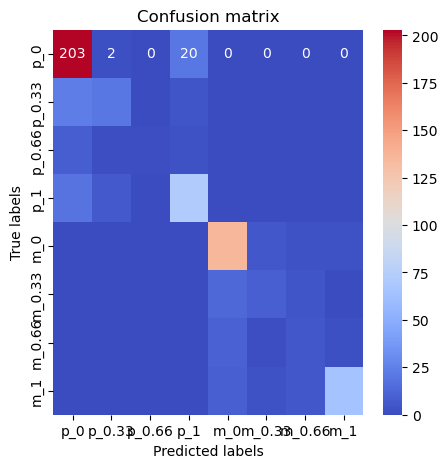

Confusion Matrix - mono:
[[136   5   3   3]
 [ 13   9   4   0]
 [ 10   1   5   2]
 [  9   3   5  65]]
Accuracy: 0.7875457875457875
Precision: 0.6330532212885154
Recall: 0.5854461546970258
F1 Score: 0.6033901040479989


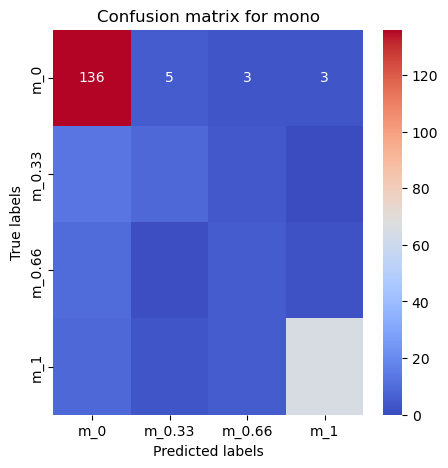

Confusion Matrix - poly
[[203   2   0  20]
 [ 23  20   0   4]
 [  8   1   1   3]
 [ 19   7   0  72]]
Accuracy: 0.7728459530026109
Precision: 0.7990777338603425
Recall: 0.5348427728974842
F1 Score: 0.5606686285699942


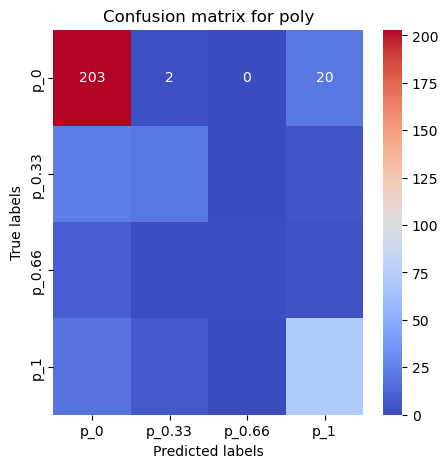

Confusion Matrix - All Types:
[[339   7   3  23]
 [ 36  29   4   4]
 [ 18   2   6   5]
 [ 28  10   5 137]]
Accuracy: 0.7789634146341463
Precision: 0.6383441351951539
Recall: 0.5658025236902833
F1 Score: 0.5910795432952781


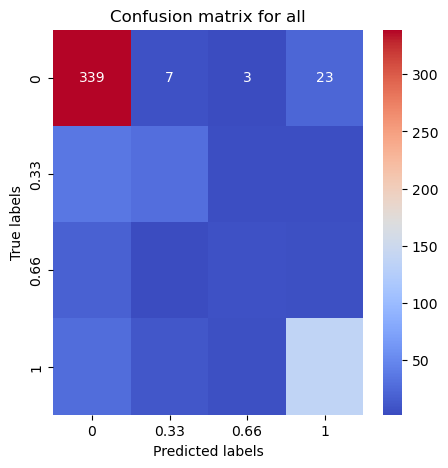

In [13]:
model.eval()
predictions = []
labels_list = []
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

class_names = ['p_0', 'p_0.33', 'p_0.66', 'p_1', 'm_0', 'm_0.33', 'm_0.66', 'm_1']

# Confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)
conf_matrix_poly = conf_matrix[:4,:4]
conf_matrix_mono = conf_matrix[4:,4:]
conf_matrix_all = conf_matrix_poly + conf_matrix_mono

accuracy, precision, recall, f1 = calculate_metrics(conf_matrix)
print('Confusion Matrix:')
print(conf_matrix)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix, class_names, 'Confusion matrix')

accuracy, precision, recall, f1 = calculate_metrics(conf_matrix_mono)
print('Confusion Matrix - mono:')
print(conf_matrix_mono)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix_mono, class_names[4:], 'Confusion matrix for mono')

accuracy, precision, recall, f1 = calculate_metrics(conf_matrix_poly)
print('Confusion Matrix - poly')
print(conf_matrix_poly)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix_poly, class_names[:4], 'Confusion matrix for poly')

accuracy, precision, recall, f1 = calculate_metrics(conf_matrix_all)
print('Confusion Matrix - All Types:')
print(conf_matrix_all)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix_all, ['0','0.33','0.66','1'], 'Confusion matrix for all')